### ME 5374 &mdash; Optimization Modeling for Engineers &mdash; Spring 2024 ###

# Where is My Fair Share? Post-Disruption Scenario Modeling for Network and Supply-Chain Resilience #

#### Diego Rivera Correa - rivera.di@northeastern.edu

*****

## Table of Contents

* [Introduction](#1.-Introduction)
    * [Supply-Chains, Network Resilience, and Max Min Fairness](#1.1-Supply-Chains,-Network-Resilience,-and-Max-Min-Fairness)
    * [Can Maximum Flow Even be Fair? (Bonus)](#1.2-Can-Maximum-Flow-Even-be-Fair?-(Bonus))
* [Mathematical Model](#2.-Mathematical-Model)
* [Solution](#3.-Solution)
    * [Libraries and Packages](#3.1-Libraries-and-Packages-Used)
    * [Initial Approach: Floating Point Upper Bounds and Lower Bounds](#3.2-Initial-Approach:-Floating-Point-Upper-Bounds-and-Lower-Bounds)
        * [Global Lower Bound](#3.2.1-Global-Lower-Bound)
        * [Max Consumer Demand as a Lower Bound](#3.2.2-Max-Consumer-Demand-as-a-Lower-Bound)
        * [Upper Bound](#3.2.3-Upper-Bound)
    * [A Mixed Integer Approach](#3.3-A-Mixed-Integer-Approach)
* [Results and Discussion](#4.-Results-and-Discussion)
    * [Initial Study: Interpretation](#4.1-Initial-Study:-Interpretation)
    * [Integer Solution: Tradeoffs, Interpretation](#4.2-Integer-Solution:-Tradeoffs,-Interpretation)
        * [Focusing on Starvation](#4.2.1-Focusing-on-Starvation)
        * [Limiting Empty Flows](#4.2.2-Limiting-Empty-Flows)
        * [Limiting the Maximum Threshold](#4.2.3-Limiting-the-Maximum-Threshold)
        * [Limiting the Disproportion](#4.2.4-Limiting-the-Disproportion)
    * [Interpreting the Results at Higher Level](#4.3-Interpreting-the-Results-at-Higher-Level)
* [Conclusion](#5.-Conclusion)
    * [Closing Remarks](#5.1-Closing-Remarks)
    * [Future Directions](#5.2-Future-Directions)
* [References](#6.-References)

## 1. Introduction ##

***

### 1.1 Supply-Chains, Network Resilience, and Max Min-Fairness ###

Supply-chain resilience is defined as the ability for a supply-chain network to withstand or to recover quickly from different types of _disruptions_ (e.g. natural disasters, operational malfunctions, etc.). Supply-chain resilience plays a vital role in today's economy by ensuring a supplier network meets demand and can quickly recover when disrupted. However, as networks expand, complexity increases, thus becoming more difficult to model, monitor, and mitigate disruptions [[1]](#6.-References). According to FEMA, around 56% of companies globally suffer annually from network disruptions, and about 60% of these companies believe they have not yet developed and applied effective supply-chain risk management practices [[3]](#6.-References).

Among the prominent research areas that address network resilience, an important one is measuring resilience as robustness, which is known as the _ability of the system to continue to function as intended in lieu of stress_ [[2]](#6.-References). Optimization is extensively used and has many applications to different aspects of network resilience as robustness, especially with network flow. In a Supply-Chain context, network flow measures are important to determine how a network can efficiently carry out a responsibility. Examples of these tasks include allocating resources, inventory, and production capacity. The network flow measure to be analyzed here is **Maximum Flow**. 

Supply-chain networks commonly have a $n$-tier structure and it the flow of commodities move downstream from a top tier to bottom a tier [[6, 7]](#6.-References). The typical tiers that appear in this supply-chain networks include nodes that fall into 3 broad categories: origin, intermediate, and destination. Figure 1 depicts a 3-tier structure, where nodes $\{2, 3\}$ represent ports, nodes $\{4, 5, 6\}$ represent distributors, and nodes $\{7, 8, 9, 10\}$ represent consumers. 2 artificial nodes $\{1, 11\}$ (representing $s$ and $t$ respectively) were created to to connect all nodes. These 2 nodes would represent the origin and destination nodes respectively, while all the aforementioned groups would fall under the category of intermediate nodes. For simplicity purposes, we are assuming that the weight of the edges represent both capacity and supply-demand (both are equal). Due to the large number of possible interconnections between these tiers, graph structures provide an effective way to model supply-chain networks. 

On the other hand, Max-Min Fairness (MMF) is a principle used in resource allocation systems (particularly Cloud Computing), ensuring equitable distribution of resources among users [[4]](#6.-References). In this concept, resources are allocated such that no user receives less than their allocated share, maximizing the minimum allocation across all users. It aims to prevent any individual user from being unfairly disadvantaged, guaranteeing that each user receives a satisfactory level of service. Max-Min Fairness is particularly relevant in scenarios with heterogeneous user requirements or limited resources, where balancing fairness and efficiency is crucial for optimizing system performance and user satisfaction. **Note: From now on, MMF and fairness will refer to the same thing.**

Consider the network pictured in Figure 1. We want to find the Max Flow from node $1$ (source $s$) to node $11$ (sink $t$). Since all edges are at their full original capacity and there are no interruptions in the network depicted in Figure 1, if we apply the original Maximum Flow formulation, the result is equal to 27, and as depicted in Figure 2, all edges received their capacity. Now, consider Figure 3, where some random disruption occurs, and the edge from node 1 to node 2 $(1,2)$ is interrupted, and its capacity diminishes from 22 to 15. If we apply the Maximum Flow again, the result decreases from 27 to 20. By taking look closer at the solution the Maximum Flow Problem provides in Figure 4, node $7$ received 15/18 of its demand and node $10$ got 5/5 of its demand. On the other hand, nodes $8$ and $9$ _starved_, meaning that they no portion of their demand was met. This begs the research question: _Is it possible to have both Maximum Flow and Max-Min Fairness? What do we need to get the best of both worlds?_

<p float="center">
  <img src="https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fdrive.google.com/uc?id=1h9wQoA6VrNMxR0-w1mhQUzKvYL8hfFzR" alt="dgre" width="40%" />
  <img src="https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fdrive.google.com/uc?id=1lxWgJV7uC1i4WAfWKB3keW0Kpd9LoxMf" alt="dgre" width="40%" />
</p>

### 1.2 Can Maximum Flow Even be Fair? (Bonus) ###

This is a bonus subsection for the 'logic' curious individuals, but feel free to skip to the remaining sections!

Recall the standard Maximum Flow LP for a network $G$ that we studied in class:

$$
\begin{aligned}
\underset{}{\text{maximize}}\qquad& \sum_{i \in V} f_{s,i} \\
\text{subject to:}\qquad&\sum_{i \in V} f_{i,j} - \sum_{i \in V} f_{j,i} = 0  && \forall j \in V - \{s, t\} && (1) \\
\\
& \sum_{i \in V} f_{s,i} = \sum_{i \in V} f_{i,t}  &&  && (2) \\
\\
& 0 \le f_{i,j} \le c_{i, j}  && \forall (i, j) \in E && (3) \\
\end{aligned}
$$

**Terminology list:**
- $G$: a directed graph with a set of nodes $V$ and edges $E$.
- $s$: Designated source node.
- $t$: Designated sink node.
- $f_{i,j}$ (decision variable): represents the flow that goes through the edge from node $i$ to node $j$.
- $c_{i, j}$: represents the capacity the edge from node $i$ to node $j$ has.

**Constraint and Expression Explanations:**
- Objective function: The objective is to maximize the amount of flow that is being sent from our source $s$ to all the other nodes $i$ it points to.
- Constraint (1): This constraint is commonly known as flow conservation. For every node outside of our source and sink, they should send out the same amount of flow they recieve.
- Constraint (2): This constraint states that to obtain Maximum Flow, the source (who only sends) and the sink (who only recieves) should have the same net flow.
- Constraint (3): This constraint states that to for each pair of edges in our graph $G$,  the flow that goes through $f_{i,j}$ must be both non-negative and obey a capacity threshold.

To make Maximum Flow 'fair', the definition of fairness has to be translatable as linear constraint. But before diving into any technical solution in the following sections, we can take a moment to reason whether a Maximum Flow with fairness constraints can be equal to a Maximum Flow without fairness constraints:

**Definition 2.1**: We define a feasible flow solution as one that satisfies all the constraints labelled in the Maximum Flow LP in [Section 1.2](#1.2-Can-Maximum-Flow-Even-be-Fair?-(Bonus)).

**Definition 2.2**: A Maximum Flow value can be seen as the maximum value of a solution space of all the feasible flows (as defined in Definition 2.1).

**Definition 2.3**: A Maximum Flow with fairness constraints is a Maximum Flow that also that satisfies all the constraints labelled in the Maximum Flow LP in [Section 1.2](#1.2-Can-Maximum-Flow-Even-be-Fair?-(Bonus)), plus an additional set of constraints that enforce a lower bound for consumer node resource allocation. As we learned in class, if we were to add an additional linear constraint to a maximization problem, the following three things may happen: We either get the same optimal value, an infeasible solution, or our optimal value may decrease.

**Theorem**: A Maximum Flow with fairness constraints ($M'$) can be equal to a Maximum Flow without fairness ($M$): $M' = M$

**Proof 1**: Prove by contradiction that: $M' \le M$. Assume that $M' > M$. Let $S'$ and $S$ be the Maximum Flow solutions for the fairness vs original version of the Maximum Flow problem, with Maximum Flow values $M'$ and $M$, respectively. Because of definition 2.3, $S'$ is also a feasible solution for the original flow problem. Because of 2.2, this implies that the Maximum Flow of the original problem must be at least $M'$. There lies a contradiction, hence, it is easy to see that any feasible solution for the Maximum Flow problem with the lower-bound constraints on the consumers is also a feasible solution for the version without those fairness constraints.

**Proof 2**: Prove by contradiction that $M' \ge M$: Assume that $M' < M$. Let $S'$ and $S$ be the Maximum Flow solutions for the fairness vs original version of the Maximum Flow problem, with Maximum Flow values $M'$ and $M$, respectively. Given that $S' < S$, that means that there is some delta flow $d$ which is lost when applying the fairness constraints ($d = S - S'$). Due to $S' < S$, we can redirect the delta flow $d$ from $S$ into $S'$. Since $S'$ is not saturated, there must be a way of redirecting delta flow $d$ without violating any of the constraints. But since we are adding more flow to $S'$, this contradicts the assumption that $S$ was a Maximum Flow.

## 2. Mathematical Model ##

***

Here the Maximum Flow Mixed Integer Program for a netowrk $G$ to maximize the flow from some designated source $s$ to a designated sink $t$: 
$$
\begin{aligned}
\underset{}{\text{maximize}}\qquad& \sum_{i \in V} f_{s,i} + \text{MMF} - k \\
\text{subject to:}\qquad&\sum_{i \in V} f_{i,j} - \sum_{i \in V} f_{j,i} = 0  && \forall j \in V - \{s, t\} && (1) \\
\\
& \sum_{i \in V} f_{s,i} = \sum_{i \in V} f_{i,t}  &&  && (2)\\
\\
& \text{MMF} \leq f_{i,t}  && \forall i \in C && (3)\\
\\
& \sum_{i \in C} z_{i, t} - \zeta \ge \gamma_{1} + (1-\gamma_{1})  &&  && (4) \\
\\
& \sum_{i \in C} f_{\text{max\_cons}, t} \le \gamma_{2} + (\text{max\_threshold}-1)(1-\gamma_{2})  &&  && (5) \\
\\
&  \sum_{j \in D_{i}} s_{j, i} = 1  && \forall i \in C && (6) \\
\\
& 0 \le f_{i,j} \le z_{i, j} c_{i, j}  && \forall (i, j) \in E && (7) \\
\\
& \sum_{i \in C} f_{\text{max\_cons}, t} - f_{\text{min\_cons}, t} \le \gamma_{3} + (\text{disp}-1)(1-\gamma_{3})  &&  && (8) \\
\\
& f_{i, j} - f_{j, i} \le Mz_{i, j} && \forall i \in C, j \in P && (9) \\
\\
& f_{j, i} - f_{i, j} \le M(1-z_{i, j}) && \forall  i \in C, j \in P && (10) \\
\\
& z_{i,j}, s_{i, j} \in \{0, 1\} && \forall (i, j) \in E && (11) \\
\\
& \gamma_{i} \in \{0, 1\} && \forall i \in \{1, 2, 3 \}  && (12)\\
\\
& M, \zeta, k \in \mathbb{Z} &&   && (13)\\
\end{aligned}
$$
    
**Terminology list:**
- $G$: a directed graph with a set of nodes $V$ and edges $E$
- $s$: Designated source node
- $t$: Designated sink node
- $C$: Set of consumer nodes (subset of $V$)
- $P$: Set of distributor nodes that are a tier before the consumer nodes (subset of $V$)
- $D_{i}$: Set of distributor nodes that connect to node $i$
- $f_{i,j}$: represents the flow that goes through the edge from node $i$ to node $j$.
- $c_{i, j}$: represents the capacity the edge from node $i$ to node $j$ has.
- $s_{i,j}$: is a Binary variable that represents whether a distributor $i$ provides flow to a consumer node $j$.
- $z_{i, j}$: is a Binary variable that represents whether edge from node $i$ to node $j$ is used or not.
- MMF: This represents the minimum allocation every consumer gets.
- $\gamma_{1}$: is a Binary variable that represents a 'Starvation Flag'. A more detailed explanation will be made while explaining the constraints.
- $\gamma_{2}$: is a Binary variable that represents a 'Max Threshold Flow Flag'. A more detailed explanation will be made while explaining the constraints.
- $\gamma_{3}$: is a Binary variable that represents a 'Disproportionate Flow Flag'. A more detailed explanation will be made while explaining the constraints.
- $\zeta$: Non-negative constant that represents the amount of allowed non-starved nodes.
- `max_threshold`: Non-negative constant that represents some threshold/upper-bound of overall network flow that the `max_cons` can have.
- `max_cons`: The consumer node with the maximum demand of flow.
- `min_cons`: The consumer node with the minimum demand of flow.
- $k$: A numerical value that represents deduction penalties from the variables $\{ \gamma_{1}, \gamma_{2}, \gamma_{3} \}$ for our overall objective.
- `disp`: Non-negative constant that represents some threshold/upper-bound for the overall flow difference between `max_cons` and `min_cons`.
- $M$: Upper-bound for the if/then constraint (9) and (10).

**Constraint and Expression Explanations:**
- Objective function: We want to maximize the sum of our Maximum Flow from a source $s$ to a sink $t$ and the overall MMF for our set of consumer nodes. 
  
- Constraint (1): This constraint is commonly known as flow conservation. For every node outside of our source and sink, they should send out the same amount of flow they recieve.
- Constraint (2): This constraint states that to obtain Maximum Flow, the source (who only sends) and the sink (who only recieves) should have the same net flow.
- Constraint (3): This constraint aims to progressively update and upper-bound our MMF allocation to the consumer with the lowest allocation (like if we were keeping track).
- Constraint (4): This constraint is an instance of a if/then condition. This enforces a penalty if the amount of non-starved consumers is less than some bound $\zeta$. A way of interpreting this is the following: Say we have 4 consumer nodes, if the sum of our consumer node binary flow variables $z$ is less or equal than 2 (which means we would have at-least 2 starving nodes), we pay a penalty.
- Constraint (5): This constraint is an instance of a if/then condition. This enforces a penalty when the `max_cons` takes a large portion of the network flow (denoted by `max_threshold`).
- Constraint (6): This constraint is an instance of a if/then condition. This enforces that if some supplier has multiple suppliers, they can only recieve flow from one of them.
- Constraint (7): This constraint states that to for each pair of edges in our graph $G$,  the flow that goes through $f_{i,j}$ must be both non-negative and obey a capacity threshold $c_{i,j}$.
- Constraint (8): This constraint is an instance of a if/then condition. This enforces that the difference between the flow of the `max_cons` and `min_cons` should be within some non-negative value $\gamma_{3}$.
- Constraint (9), (10): This is a two-part if/then condition. This enforces that if there is a distributor node with multiple consumers that it can link to, it will give a higher priority to the consumer with lower demand.
- Constraint (11) and (12): This states that our Binary variables must naturally be valued in the set $\{ 0, 1 \}$
- Constraint (13): Upper-bound $M$, $\zeta$, and $k$ must be some integer.



**Assumption Made**:
- The core assumption for this type of problem is that any disruption does not remove an edge (i.e. makes it capacity 0) and that there is at least one path from the source that can reach any consumer node.

## 3. Solution ##

***

The following section includes the fundamental code for the models used to solve this problem.

### 3.1 Libraries and Packages Used ###

In the following cell, we import all the necessary libraries that will be leveraged for the project! Remember to use `Pkg` to add the libraries you don't have!

In [2]:
using JuMP, HiGHS, GLPK, Plots, DataFrames, CSV

In [45]:
function k()
    return 1, 2
end

k (generic function with 1 method)

In [47]:
k()[2]

2

### 3.2 Initial Approach: Floating Point Upper Bounds and Lower Bounds

The following sub-section outlines some techniques from an initial study I conducted this semester as part of my research. These techniques aim to enforce fairness for the Maximum Flow problem. In the results section, there will be a brief analysis that summarizes the pros and cons of each technique. Recall the definition for a fair Maximum Flow, which ensures all consumers get some non-negative fraction of their demand met. For the next 3 subsections, consider each fairness constraint independently as if you were adding it to the Maximum Flow LP in [Section 1.2](#1.2-Can-Maximum-Flow-Even-be-Fair?-(Bonus))

In [61]:
function max_flow_with_fairness(fairness_parameter, alpha, printInfo)
    # Function parameters
        # fairness_parameter: one of the 3 methods
        # alpha: upper/lower bound between [0,1]
        # printInfo: boolean flag to determine if you want to print the results
    
    # Define the graph parameters for the Max Flow algorithm
    ####################### DATA PREP #######################
    num_nodes = 11 # graph size
    source = 1 # s
    sink = 11 # t

    # Define the capacity matrix
    # row down is node, column right is edge
    capacity_matrix = [
        0 13 5  0 0 0  0 0 0 0  0;
        0  0 0 13 9 0  0 0 0 0  0;
        0  0 0  0 0 5  0 0 0 0  0;
        0  0 0  0 0 0 13 0 0 0  0;
        0  0 0  0 0 0  5 3 4 0  0;
        0  0 0  0 0 0  0 0 0 5  0;
        0  0 0  0 0 0  0 0 0 0 18;
        0  0 0  0 0 0  0 0 0 0  3;
        0  0 0  0 0 0  0 0 0 0  4;
        0  0 0  0 0 0  0 0 0 0  5;
        0  0 0  0 0 0  0 0 0 0  0;
    ]
    
    pred_cons = [4, 5, 6] # predecessors to the consumers
    consumers = [7, 8, 9, 10] # target consumer nodes

    # set difference between consumers and any another node
    noncos = [1, 7, 8, 9, 10,11]

    # data structure with arbitrary values to reference in some constraints
    demand_dict = Dict(7 => 18, 8 => 3, 9 => 4, 10 => 5) # node -> its demand
    max_cons = findmax(demand_dict)[2] # node 7
    min_cons = findmin(demand_dict)[2] # node 8
    ####################### DATA PREP #######################

    ### Model initialization and basic constraints ###
    # Create a JuMP model with the HiGHS solver
    model = Model(HiGHS.Optimizer)
    set_optimizer_attribute(model, MOI.Silent(), true)

    # Define the flow variables
    @variable(model, 0.0 <= flow[i=1:num_nodes, j=1:num_nodes] <= capacity_matrix[i, j])

    @variable(model, min_allocation) # variable to keep track of the minimum allocation across consumers
    # keeping track and bound our MMF allocation 
    for c in consumers
        @constraint(model, min_allocation <= flow[c, sink])
    end

    # Define the flow conservation constraints
    @constraint(model, [i=2:num_nodes-1], sum(flow[j, i] for j=1:num_nodes if j!= i) - sum(flow[i, k] for k=1:num_nodes if k!=i) == 0)

    # Define the capacity constraints for each edge
    @constraint(model, capacity_constraint[i=1:num_nodes, j=1:num_nodes], flow[i, j] <= capacity_matrix[i, j])
    ### Model initialization and basic constraints ###

    ### DECISION TO CHOOSE THE FAIRNESS MEASURE ###
    if fairness_parameter == 1
        if printInfo == true
            println("Alright! Lets run a Maximum Flow with no fairness constraints!")
        end
    elseif fairness_parameter == 2
        if printInfo == true
        # add constraint
            println("Alright! Lets run a Maximum Flow with a lower bound!")
        end
        # make sure each consumer earns some alpha percent of their demand.
        @constraint(model, [c ∈ consumers], sum(flow[j, c] for j=1:num_nodes if j ∉ noncos ) >= alpha*demand_dict[c])
    elseif fairness_parameter == 3
        # add constraint
        if printInfo == true
            println("Alright! Lets run a Maximum Flow with a relative lower bound!")
        end
        # make sure each consumer earns some alpha percent of what the highest earner consumes.
        @constraint(model, [c ∈ consumers], sum(flow[j, c] for j=1:num_nodes if j ∉ noncos ) >= alpha*sum(flow[j, max_cons] for j=1:num_nodes if j ∉ noncos ))
    else
        # add constraint
        if printInfo == true
            println("Alright! Lets run a Maximum Flow with an upper bound!")
        end
        # apply an upper bound to how much each node can get.
        @constraint(model, [c ∈ consumers], (sum(flow[j, c] for j=1:num_nodes if j ∉ noncos ) / demand_dict[c]) <= alpha)
    end
     ### DECISION TO CHOOSE THE FAIRNESS MEASURE ###

    # Define the objective function (maximize the flow out of the source)
    @objective(model, Max, sum(flow[source, j] for j=1:num_nodes if j!=source))
    # Solve the linear program
    optimize!(model)

    #### POST PROCESSING AND DATA FORMAT ####
    # if its infeasible, we return a dummy value
    if has_values(model) == false
        return -1.0
    end

    # flag to determine whether all consumers got flow
    fair = false
    consumer_totals = Dict(7 => 0.0, 8 => 0.0, 9 => 0.0, 10 => 0.0)

    # loop through the consumers and find the flows they recieved, and store them in the dictionary
    for i in 1:num_nodes
        for j in consumers
            if capacity_matrix[i,j] > 0
                consumer_totals[j] += value(flow[i, j])
            end
        end
    end

    # if there was starvation, we set the flag to true
    if 0.0 ∉ values(consumer_totals)
        fair = true
    end

    ##### FORMAT TO PRINT THE SOLUTION TO OUR GRAPH #####
    if fair != false
        if printInfo == true
            println("Fairness can be achieved!")
            println("Optimal Fair Flow: ", objective_value(model))
            println("Flow Breakdown:")
            for i in 1:num_nodes
                for j in 1:num_nodes
                    if capacity_matrix[i,j] > 0
                        println("Flow from node $i to node $j = ", value(flow[i, j]))
                    end
                end
            end
        end
        #### return min
        return objective_value(model), value(min_allocation)
        # return objective_value(model)
    else
        if printInfo == true
            println("Fairness is not achieved!")
            println("Optimal Non-Fair Flow: ", objective_value(model))
            println("Flow Breakdown:")
            for i in 1:num_nodes
                for j in 1:num_nodes
                    if capacity_matrix[i,j] > 0
                        println("Flow from node $i to node $j = ", value(flow[i, j]))
                    end
                end
            end
        end
        return -1.0, -1.0 # if fairness was not achieved, return a dummy value
    end
    ##### FORMAT TO PRINT THE SOLUTION TO OUR GRAPH #####
    #### POST PROCESSING AND DATA FORMAT ####
end

max_flow_with_fairness (generic function with 1 method)

In [62]:
#### running the max_flow_with_fairness() with a specific fairness case ####
max_flow_with_fairness(1, 0.0, true)
!
#### running the max_flow_with_fairness() with a specific fairness case ####

Alright! Lets run a Maximum Flow with no fairness constraints!
Fairness is not achieved!
Optimal Non-Fair Flow: 18.0
Flow Breakdown:
Flow from node 1 to node 2 = 13.0
Flow from node 1 to node 3 = 5.0
Flow from node 2 to node 4 = 13.0
Flow from node 2 to node 5 = -0.0
Flow from node 3 to node 6 = 5.0
Flow from node 4 to node 7 = 13.0
Flow from node 5 to node 7 = 0.0
Flow from node 5 to node 8 = 0.0
Flow from node 5 to node 9 = 0.0
Flow from node 6 to node 10 = 5.0
Flow from node 7 to node 11 = 13.0
Flow from node 8 to node 11 = -0.0
Flow from node 9 to node 11 = -0.0
Flow from node 10 to node 11 = 5.0


! (generic function with 4 methods)

Notice from the output from above that both consumers $8$ and $9$ did not recieve any flow, meaning that they _starved_. 

#### 3.2.1 Global Lower Bound 

This measure focuses on finding all the consumer nodes of a network and enforcing that all of them receive at least some $\alpha$ percent of their capacity. The notation of the fairness measure as a linear constraint can be written as the following: $$ \alpha c_{i,j} \leq f_{i,j} \quad\quad \forall (i, j) \in E $$ Where $\alpha$ is a number within $[0,1]$, and $E$ is the set of edges. If you forgot about the other terms, check the Maximum Flow LP **Terminology** and **Constraint Explanation** in [Section 1.2](#1.2-Can-Maximum-Flow-Even-be-Fair?-(Bonus))

In [63]:
#### running the max_flow_with_fairness() with a specific fairness case ####
global_fairness = 2 # Global Lower Bound 
alpha_lower = .52 # sample bound, try another value!
max_flow_with_fairness(global_fairness, alpha_lower, true)
!
#### running the max_flow_with_fairness() with a specific fairness case ####

Alright! Lets run a Maximum Flow with a lower bound!
Fairness can be achieved!
Optimal Fair Flow: 18.0
Flow Breakdown:
Flow from node 1 to node 2 = 13.0
Flow from node 1 to node 3 = 5.0
Flow from node 2 to node 4 = 9.36
Flow from node 2 to node 5 = 3.64
Flow from node 3 to node 6 = 5.0
Flow from node 4 to node 7 = 9.36
Flow from node 5 to node 7 = 0.0
Flow from node 5 to node 8 = 1.56
Flow from node 5 to node 9 = 2.08
Flow from node 6 to node 10 = 5.0
Flow from node 7 to node 11 = 9.36
Flow from node 8 to node 11 = 1.56
Flow from node 9 to node 11 = 2.08
Flow from node 10 to node 11 = 5.0


! (generic function with 4 methods)

From the previous output, the nodes that we want some flow go through them are nodes $[7, 8,9, 10]$, and luckily they did get flow!

#### 3.2.2 Max Consumer Demand as a Lower Bound

This approach focuses on selecting the consumer node that has the highest demand among all consumer nodes. By selecting the highest earning consumer node's demand and assigning it to a variable $k$, the fairness constraint enforces that every other consumer node should get at least some $\alpha$ percent of $k$. $$\alpha k \leq \sum_{j \in V} f_{j,i} \quad\quad \forall i \in C $$ Where $\alpha$ is a number within $[0,1]$, and $C$ is the set of consumer nodes (which is a subset of $V$). If you forgot about the other terms, check the Maximum Flow LP **Terminology** and **Constraint Explanation** in [Section 1.2](#1.2-Can-Maximum-Flow-Even-be-Fair?-(Bonus))

In [64]:
#### running the max_flow_with_fairness() with a specific fairness case ####
relative_fairness = 3 # Max Consumer Demand as a Lower Bound
alpha_lower = .7 # sample bound, try another value!
max_flow_with_fairness(relative_fairness, alpha_lower, true) 
!
#### running the max_flow_with_fairness() with a specific fairness case ####

Alright! Lets run a Maximum Flow with a relative lower bound!
Fairness can be achieved!
Optimal Fair Flow: 16.285714285714285
Flow Breakdown:
Flow from node 1 to node 2 = 11.285714285714285
Flow from node 1 to node 3 = 5.0
Flow from node 2 to node 4 = 4.285714285714286
Flow from node 2 to node 5 = 7.0
Flow from node 3 to node 6 = 5.0
Flow from node 4 to node 7 = 4.285714285714286
Flow from node 5 to node 7 = 0.0
Flow from node 5 to node 8 = 3.0
Flow from node 5 to node 9 = 4.0
Flow from node 6 to node 10 = 5.0
Flow from node 7 to node 11 = 4.285714285714286
Flow from node 8 to node 11 = 3.0
Flow from node 9 to node 11 = 4.0
Flow from node 10 to node 11 = 5.0


! (generic function with 4 methods)

From the previous output, the nodes that we want some flow go through them are nodes $[7, 8,9, 10]$, and luckily they did get flow!

#### 3.2.3 Upper Bound

This approach focuses on ensuring that the ratio of a consumer's inflow over their demand must be less than some $\alpha$ value. A high-level view of the fairness constraint is the following: $$\frac{\sum f_{j,i}}{c_{j,i}} \leq \alpha \quad\quad \forall i \in C, j \in D_i $$ Where $\alpha$ is a number within $[0,1]$, and $C$ is the set of consumer nodes (which is a subset of $V$). If you forgot about the other terms, check the Maximum Flow LP **Terminology** and **Constraint Explanation** in [Section 1.2](#1.2-Can-Maximum-Flow-Even-be-Fair?-(Bonus))

In [65]:
#### running the max_flow_with_fairness() with a specific fairness case ####
global_fairness = 4 # Upper Bound
alpha_upper = .59 # sample bound, try another value!
max_flow_with_fairness(global_fairness, alpha_upper, true)
!
#### running the max_flow_with_fairness() with a specific fairness case ####

Alright! Lets run a Maximum Flow with an upper bound!
Fairness can be achieved!
Optimal Fair Flow: 15.95
Flow Breakdown:
Flow from node 1 to node 2 = 13.0
Flow from node 1 to node 3 = 2.9499999999999997
Flow from node 2 to node 4 = 10.62
Flow from node 2 to node 5 = 2.380000000000001
Flow from node 3 to node 6 = 2.9499999999999997
Flow from node 4 to node 7 = 10.62
Flow from node 5 to node 7 = 0.0
Flow from node 5 to node 8 = 0.020000000000000906
Flow from node 5 to node 9 = 2.36
Flow from node 6 to node 10 = 2.9499999999999997
Flow from node 7 to node 11 = 10.62
Flow from node 8 to node 11 = 0.020000000000000906
Flow from node 9 to node 11 = 2.36
Flow from node 10 to node 11 = 2.9499999999999997


! (generic function with 4 methods)

From the previous output, the nodes that we want some flow go through them are nodes $[7, 8,9, 10]$, and luckily they did get flow!

### 3.3 A Mixed Integer Approach ####

The following section provides the formulation for the Mixed-Integer and 'fair' version of our Maximum Flow Linear Program. The reasons as to why we are establishing a Mixed-Integer approach are the following: By using Integers, we create all-or-nothing scenarios, which are more useful to study tradeoffs. Additionally, in a supply-chain context, stakeholders and managers would not want to work with some specific $\alpha$ values, they would rather make decisions based on the penalties and infractions that some network may incurr from not getting flow (like profit, energy consumption, among other company metrics [[1](#6.-References)]). Additionally, Mixed-Integer Program formulations often result in models that are easier to interpret and understand. This can be beneficial for analyzing the fairness constraints and ensuring that they accurately capture the desired behavior. It also enables formulations that provide flexibility in incorporating more complex constraints to ensure fairness. This being said, as we saw in the previous subsection, though some 'fairness' can be obtained by adding simple constraints, having to decide between if/then conditions can make a more realistic simulation for these supply-chains.

In [8]:
function MI_Fair_MF(starvation, empty_flows, max_thresh, disp, big_M, weights, printInfo)
    # Function parameters
        # starvation_pen: the upper bound on the amount of consumer nodes without flow (in this case, the max is 4)
        # empty_flows: the upper bound on the amount of consumer nodes without flow (in this case, the max is 4)
        # max_thresh: upper bound that indicates how much flow the max consumer can get
        # disp: upper bound that indicates the maximum flow difference between the max_consumer and min_consumer
        # big_M: upper bound for the (typically BIG, default 1000)
        # weights: weights used for tradeoff analysis in the next section (set it (1, 0) to run directly).
        # printInfo: Boolean flag to determine whether you print the results or not.
    
    # Define the graph parameters for the Max Flow algorithm
    ####################### DATA PREP #######################
    
    capacity_matrix = [
        0 13 5  0 0 0  0 0 0 0  0;
        0  0 0 13 9 0  0 0 0 0  0;
        0  0 0  0 0 5  0 0 0 0  0;
        0  0 0  0 0 0 13 0 0 0  0;
        0  0 0  0 0 0  5 3 4 0  0;
        0  0 0  0 0 0  0 0 0 5  0;
        0  0 0  0 0 0  0 0 0 0 18;
        0  0 0  0 0 0  0 0 0 0  3;
        0  0 0  0 0 0  0 0 0 0  4;
        0  0 0  0 0 0  0 0 0 0  5;
        0  0 0  0 0 0  0 0 0 0  0;
    ]

    # constants
    profit_per_unit = 5 # dummy value
    starvation_penalty = starvation
    empty_flow_count = empty_flows
    flow_deduction = 4 # dummy value
    # constants

    # identifiers for supply-chain structure
    pred_cons = [4, 5, 6] # nodes that connect to consumers
    consumers = [7, 8, 9, 10]
    # data structure with arbitrary values to reference in some constraints
    demand_dict = Dict(7 => 18, 8 => 3, 9 => 4, 10 => 5) # node -> its demand
    max_cons = findmax(demand_dict)[2] # 7
    min_cons = findmin(demand_dict)[2] # 8
    num_nodes = 11 # size
    source = 1 # s
    sink = 11 # t
    # identifiers for supply-chain structure
    
    # Create a JuMP model with the HiGHS solver
    model = Model(HiGHS.Optimizer)
    set_optimizer_attribute(model, MOI.Silent(), true)
    
    # Define the model variables
    @variable(model, 0 <= flow[i=1:num_nodes, j=1:num_nodes]) # flow variable
    @variable(model, z[i=1:num_nodes, j=1:num_nodes], Bin) # binary variable to determine if flow is used or not
    @variable(model, supply_limit[i=4:6, j=6:10], Bin) # binary variable that represents whether a distributor i provides flow to a consumer node j
    @variable(model, min_allocation) # variable to keep track of the minimum allocation across consumers
    @variable(model, starvation_pen, Bin) # equivalent to gamma1 from our formulation
    @variable(model, max_carrier, Bin) # equivalent to gamma2 from our formulation
    @variable(model, disproportion_pen, Bin) # equivalent to gamma3 from our formulation
    
    # Define the flow conservation constraints
    @constraint(model, [i=2:num_nodes-1], sum(flow[j, i] for j=1:num_nodes if j!= i) - sum(flow[i, k] for k=1:num_nodes if k!=i) == 0)

    # Make sure that whatever the source sends if the same amount that the sink recieves
    @constraint(model, sum(flow[source, j] for j=1:num_nodes if j != source) == sum(flow[k, sink] for k=1:num_nodes if k!=sink))
    
    # Define the capacity constraints for each edge
    @constraint(model, capacity_constraint[i=1:num_nodes, j=1:num_nodes], flow[i, j] <= z[i, j]*capacity_matrix[i, j])
    @constraint(model, non_constraint[i=1:num_nodes, j=1:num_nodes], z[i, j] <= flow[i, j])

    # keeping track and bound our MMF allocation 
    for c in consumers
        @constraint(model, min_allocation <= flow[c, sink])
    end
    
    ##### IF THEN CONSTRAINTS #####
    # case 1: condition for starving a certain number of consumers
    @constraint(model, starvation_penalty, sum(z[i, sink] for i in consumers) - empty_flow_count >= starvation_pen + (1-starvation_pen))
    
    # case 2: condition for which a majority carrier's flow should be diminished if it exceeds some particular threshold.
    max_t = max_thresh
    @constraint(model, majority_carrier, flow[max_cons, sink] <= max_carrier + (max_t-1)*(1-max_carrier))
    
    M = big_M
    # case 3: prioritize lower allocation
    for pred in pred_cons
        for node in consumers
            if node != pred
                @constraint(model, flow[node, pred] - flow[pred, node] <= M*z[node, pred])
                @constraint(model, flow[pred, node] - flow[node, pred] <= M*(1 - z[node, pred]))
            end
        end
    end
    
    # case 4: every consumer should have at most only choose one supplier
    for consumer in consumers
        @constraint(model, sum(supply_limit[d, consumer] for d in pred_cons) == 1)
    end
    
    # case 5: disproportion penalty if the flow difference between the max and min consumer exceeds a penalty
    disproportion = disp
    @constraint(model, flow[max_cons, sink] - flow[min_cons, sink] <= 1*disproportion_pen + (disproportion-1)*(1-disproportion_pen))
    ##### IF THEN CONSTRAINTS #####

    # define possible penalty and infraction
    k = starvation_pen  + max_carrier + disproportion_pen

    # Define the objective function (maximize the flow out of the source), maximizing minimum allocation
    # Objective: Standard Max-Flow + MMF allocation
    @objective(model, Max, sum(flow[source, j] for j=1:num_nodes if j!=source)*weights[1] + weights[2]*(min_allocation) - 5k)
    
    # Solve the linear program
    optimize!(model)

    if printInfo == true
        # display the results for the experiment
        # we display the value for both our objectives, and if our penalties were used.
        println("Maximum Flow = ", sum(value(flow[source, j]) for j=1:num_nodes if j!=source))
        println("MMF Min Allocation = ", value(min_allocation))
        println("Did we incurr a starvation penalty? ", value(starvation_pen) == 1)
        println("Did we incurr a Max Carrier penalty? ", value(max_carrier) == 1)
        println("Did we incurr a Disproportionate Flow penalty? ", value(disproportion_pen) == 1)

        # display the results for the experiment
        for i in 1:num_nodes
            for j in 1:num_nodes
                if capacity_matrix[i,j] > 0
                    println("Flow[$i, $j] = ", value(flow[i, j]))
                end
            end
        end
    end
    # return the maximum flow value and the MMF value
    return sum(value(flow[source, j]) for j=1:num_nodes if j!=source) - value(5k), value(min_allocation) - value(5k)
end

MI_Fair_MF(10, 1, 10, 15, 1000, (1, 0), true)

Maximum Flow = 18.0
MMF Min Allocation = 1.0
Did we incurr a starvation penalty? false
Did we incurr a Max Carrier penalty? false
Did we incurr a Disproportionate Flow penalty? false
Flow[1, 2] = 13.0
Flow[1, 3] = 5.0
Flow[2, 4] = 4.0
Flow[2, 5] = 9.0
Flow[3, 6] = 5.0
Flow[4, 7] = 4.0
Flow[5, 7] = 5.0
Flow[5, 8] = 3.0
Flow[5, 9] = 1.0
Flow[6, 10] = 5.0
Flow[7, 11] = 9.0
Flow[8, 11] = 3.0
Flow[9, 11] = 1.0
Flow[10, 11] = 5.0


(18.0, 1.0)

## 4. Results and Discussion ##

***

The following section provides some insights and interpretations for the code and formulations from the previous sections.

### 4.1 Initial Study: Interpretation ###

The following 2 cells perform some data collection for the initial study experiments mentioned in section [3.2](#3.2-Initial-Approach:-Floating-Point-Upper-Bounds-and-Lower-Bounds). A simulation is performed where each LP with their fairness constraint is solved for a variety of $\alpha$ values until each LP is infeasible.

In [80]:
# Given some fairness option, we perform the simulation for the LP with multiplte alpha values until infeasible
function CollectDataScatter(fair)
    if fair != 4 
        # if the option is not an upper bound, we configure each parameter to its corresponding place
        alphaval = 0.0
        upperBoundalphaM = []
        maxFlowM = []
        # perform at most 100 simulations
        for i in 1:100
            alphaval = (i*1.0)/100.0
            values = max_flow_with_fairness(fair, alphaval, false)
            # println(values)
            # println(val, min)
            # if feasible, add it to the datastructure, if not, exit and return
            if values != -1.0
                val = values[1]
                min = values[2]
                push!(upperBoundalphaM, min)
                push!(maxFlowM, val)
            else
                break
            end
        end
        return upperBoundalphaM, maxFlowM
    else
        # if the option is an upper bound, we configure each parameter to its corresponding place
        lowerBoundalphaM = []
        maxFlowM = []
        epsilon = 0.0
        # perform at most 100 simulations
        for i in 1:100
            epsilon = (i*1.0)/100.0
            values = max_flow_with_fairness(4, epsilon, false)
            # if feasible, add it to the datastructure, if not, exit and return
            if values != -1.0
                val = values[1]
                min = values[2]
                push!(lowerBoundalphaM, min)
                push!(maxFlowM, val)
            else
                break
            end
        end
        return lowerBoundalphaM, maxFlowM
    end
end

CollectDataScatter (generic function with 1 method)

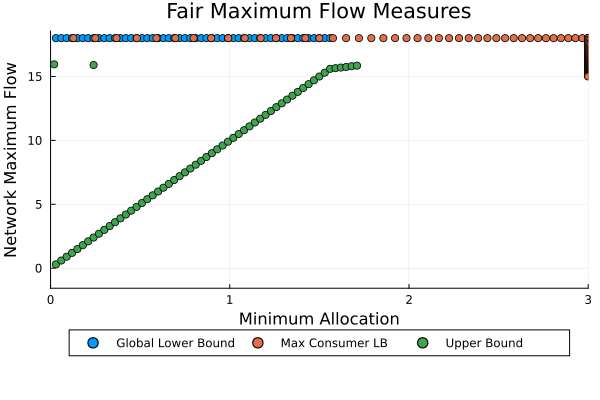

In [94]:
alpha1, mf1 = CollectDataScatter(2) # lower bound fairness measure
alpha2, mf2 = CollectDataScatter(3) # max consumer as lower bound fairness measure
alpha3, mf3 = CollectDataScatter(4) # upper bound fairness measure

scatter(alpha1, mf1, label="Global Lower Bound")
scatter!(alpha2, mf2, label="Max Consumer LB")
scatter!(alpha3, mf3, label="Upper Bound")
xlims!(0,3)
plot!(legend=:outerbottom, legendcolumns=3)
title!("Fair Maximum Flow Measures")
xlabel!("Minimum Allocation")
ylabel!("Network Maximum Flow")

In [49]:
# Given some fairness option, we perform the simulation for the LP with multiplte alpha values until infeasible
function CollectData(fair)
    if fair != 4 
        # if the option is not an upper bound, we configure each parameter to its corresponding place
        alphaval = 0.0
        upperBoundalphaM = []
        maxFlowM = []
        # perform at most 100 simulations
        for i in 1:100
            alphaval = (i*1.0)/100.0
            val = max_flow_with_fairness(fair, alphaval, false)[1]
            # if feasible, add it to the datastructure, if not, exit and return
            if val != -1.0
                push!(upperBoundalphaM, alphaval)
                push!(maxFlowM, val)
            else
                break
            end
        end
        return upperBoundalphaM, maxFlowM
    else
        # if the option is an upper bound, we configure each parameter to its corresponding place
        lowerBoundalphaM = []
        maxFlowM = []
        epsilon = 0.0
        # perform at most 100 simulations
        for i in 1:100
            epsilon = (i*1.0)/100.0
            val = max_flow_with_fairness(4, epsilon, false)[1]
            # if feasible, add it to the datastructure, if not, exit and return
            if val != -1.0
                push!(lowerBoundalphaM, epsilon)
                push!(maxFlowM, val)
            else
                break
            end
        end
        return lowerBoundalphaM, maxFlowM
    end
end

CollectData (generic function with 1 method)

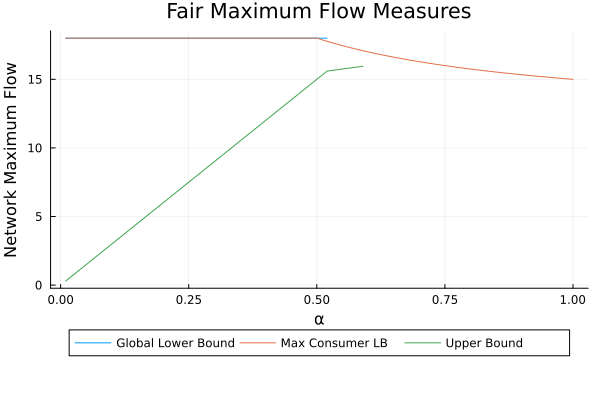

In [50]:
alpha1, mf1 = CollectData(2) # lower bound fairness measure
alpha2, mf2 = CollectData(3) # max consumer as lower bound fairness measure
alpha3, mf3 = CollectData(4) # upper bound fairness measure

plot(alpha1, mf1, label="Global Lower Bound")
plot!(alpha2, mf2, label="Max Consumer LB")
plot!(alpha3, mf3, label="Upper Bound")
plot!(legend=:outerbottom, legendcolumns=3)
title!("Fair Maximum Flow Measures")
xlabel!("α")
ylabel!("Network Maximum Flow")

The graph above simulates each fairness constraint from an initial $\alpha = 0$ until each instance of the fair Maximum Flow LP is infeasible. At a glance, we can see that as $\alpha$ is a small value, both the **Global Lower Bound** and **Max Consumer as Lower Bound** are the dominant strategy, since these can both obtain some level of Max-Min-Fairness, while not sacrificing any network flow. On the other hand, since the **Max Consumer as Lower Bound** constraint takes the entirety of the consumers and tries to balance them, we see that it was able to perform all simulations for every $\alpha$ value, but as we increase the 'fairness', the overall network max flow decreases. Meanwhile, the **Upper Bound** metric always seems to be a losing strategy compared to the other metrics. Of course, this points back to how subjective the notions of fairness are, and one might ask themselves: _When is it fair to limit how much people can get?_ But to really interpret what we are looking at, lets breakdown each case:

**Consider the `capacity_matrix` from the function `max_flow_with_fairness` from [Section 3.2](#3.2-Initial-Approach:-Floating-Point-Upper-Bounds-and-Lower-Bounds) for the following simulations**

- **Global Lower Bound (blue line)**: On the positive side, this measure is a quick fix that can also be solved in polynomial time and can guarantee that all nodes get some demand met (when feasible). On the other hand, depending on what value of $\alpha$ is used, there might be a solution in which if someone picks a very low $\alpha$ value vs its highest possible value, the 'fair' resource allocation still might be insignificant. Though a search method like Binary Search may remediate this possible setback, what follows is determining how precise should the $\alpha$ value be. The negative side of this measure is that if we were to have a more interconnected network and there were multiple disruption across different suppliers, one $\alpha$ may be insufficient to cover all consumer nodes, and may sway the demand to one side of the network. This would then require some way of partitioning graphs, which is outside of the scope of this type of project. As we increase the $\alpha$ value, depending on how disproportionate the demand for all consumers is, we can a solution that both provides fairness, parity, and overall network Maximum Flow. The following table summarizes how the consumer inflow breaks down as the $\alpha$ values increase:
  
| $\alpha$ | node 7 inflow | node 8 inflow | node 9 inflow | node 10 inflow |
|:-------:|:-------:|:------:|:------:|:----:|
| .10   | 12.3  | 0.3  | 0.1  | 5  |
| .20   | 11.6  | 0.6  | 0.8  | 5  |
| .30   | 10.9  | 0.89 | 1.2  | 5  |
| .40   | 10.2  | 1.2  | 1.6  | 5  |
| .50   | 9.5   | 1.5  | 2.0  | 5  |
| .52   | 9.36  | 1.56 | 2.08 | 5  |


- **Max Consumer LB (orange line)**: The simulation showed that if we increase the $\alpha$ value, the Maximum Flow decreases and will eventually plateau at a certain value. This is due to the fact that the only way to guarantee that every node gets $\alpha$ percent while satisfying the original Maximum Flow capacity constraints, a portion of demand for the consumer with the highest demand would have to be subtracted. 2 observations: First, notice that if a consumer node earns 0, the only feasible solution with this type of constraint is that everyone should get 0, which would strictly go against any actual notion of fairness. So in a basic sense, this constraint bounds everyone within a specific range, which increases the MMF, but decreases network flow. Second, there is a point in the graph where the Maximum Flow stayed approximately the same even if the $\alpha$ value increased. This means that the share of demand was very little, and as we approach higher shares, the Maximum Flow decreases. The following is how the consumer inflow breaks down as the $\alpha$ values increase:

| $\alpha$ | node 7 inflow | node 8 inflow | node 9 inflow | node 10 inflow |
|:-------:|:---------------:|:---------------:|:---------------:|:----------------:|
| 0.1   | 10.83         | 1.08          | 1.083         | 5              |
| 0.2   | 9.28          | 1.85          | 1.85          | 5              |
| 0.3   | 8.12          | 2.43          | 2.43          | 5              |
| 0.4   | 7.22          | 2.88          | 2.88          | 5              |
| 0.5   | 6             | 3             | 4             | 5              |
| 0.6   | 5             | 3             | 4             | 5              |
| 0.7   | 4.28          | 3             | 4             | 5              |
| 0.8   | 3.75          | 3             | 4             | 5              |
| 0.9   | 3.33          | 3             | 4             | 5              |
| 1     | 3             | 3             | 4             | 5              |

- **Upper Bound (green line)**: The simulation showed that if we increase the $\alpha$ value, the Maximum Flow increases and becomes less fair (notice node 8's inflow). This is due to the fact that if we let nodes recieve their full demand, the problem shifts towards the original Maximum Flow problem. But as the $\alpha$ value approaches 0, the amount of demand nodes can get is low, and the demand that is not used gets sent to the consumers who originally _starved_ in the original problem. The main problem with this approach is that if we were to limit how much a node can get, we may subtract demand from other nodes whose sub-network is not affected (refer to Figure 3 in [Section 1.1](#1.1-Supply-Chains,-Network-Resilience,-and-Max-Min-Fairness), where node $10$ is in some other non-affected region of the supply-chain, but we are forcing it to earn less), or their might be unused resources, which inherently goes against the purpose of Maximum Flow. The following is how the consumer inflow breaks down as the $\alpha$ values increase:

| $\alpha$ | node 7 inflow | node 8 inflow | node 9 inflow | node 10 inflow |
|:-------:|:---------------:|:---------------:|:---------------:|:----------------:|
| 0.1   | 1.8           | 0.3           | 0.4           | 0.5            |
| 0.2   | 3.6           | 0.6           | 0.8           | 1              |
| 0.3   | 5.4           | 0.9           | 1.2           | 1.5            |
| 0.4   | 7.2           | 1.2           | 1.6           | 2              |
| 0.5   | 9             | 1.5           | 2.0           | 2.5            |
| 0.6   | 10.62         | 0.02          | 2.36          | 2.95           |

### 4.2 Integer Solution: Tradeoffs, Interpretation

The following section performs a discussion on the possible tradeoffs we have with our 2 objectives (Maximum Flow and MMF). Even though both objectives have somewhat of a correlation, this section aims to confirm and prove that you can possibly improve both objectives simultaneously without having to impact each other.

In [11]:
# this function runs the Mixed-Integer version of our program and computes the Pareto frontier for our
# 2 objectives (MMF and Maximum Flow)
function tradeoffMIP(focus, starvation_pen, empty_flows, max_thresh, disp, big_M)
    # create the weights for the tradeoffs
    # focus: title for Pareto tradeoff
    # starvation_pen: the upper bound on the amount of consumer nodes without flow (in this case, the max is 4)
    # empty_flows: the upper bound on the amount of consumer nodes without flow (in this case, the max is 4)
    # max_thresh: upper bound that indicates how much flow the max consumer can get
    # disp: upper bound that indicates the maximum flow difference between the max_consumer and min_consumer
    # big_M: upper bound for the (typically BIG)
    weights = 10 .^ LinRange(0, 1, 1000)
    x = [] # max flow values
    y = [] # MMF
    for ws in weights
        # solve the LP with the weights
        opt = MI_Fair_MF(starvation_pen, empty_flows, max_thresh, disp, big_M, (1-ws, ws), false)
        x_opt, y_opt = opt[1], opt[2]
        push!(x, x_opt)
        push!(y, y_opt)
    end

    # plot the solutions and Pareto Frontier
    plot(x, y, label="Pareto Frontier", xlabel="Maximum Flow", ylabel="MMF")
    plot!(x,y, fill=(0, :blue), fillalpha=0.3, linewidth=0, label="strictly sub-optimal set")
    scatter!(x, y, label="Pareto Optimal Points")
    title!("Optimal Tradeoff: $(focus)")
end

tradeoffMIP (generic function with 1 method)

#### 4.2.1 Focusing on Starvation

For the following graphs, we will run our function from section [Section 3.3](#3.3-A-Mixed-Integer-Approach). The plan is to fix all the variables outside of the one the subsection focuses on. In this case, we focus on `starvation_pen`, which is explained in our formulation from the previous section!

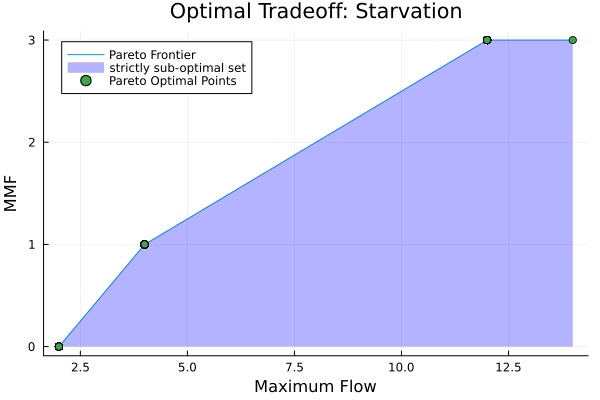

In [12]:
#### SCHEMA #####
############ focus ###### starvation_pen ### empty_flows #######  max_thresh ###### disp ####### bigM
tradeoffMIP("Starvation",      10,            1,                    10,              15,         1000)
# set starvation to 1

**Interpretation for graph above**: After running the tradeoff curve for multiple values of `starvation_pen`, the same graph was obtained. We can see the presence of 4 vertices suggests that there are numerous distinct trade-offs between the two objectives. What is most important to note is that there are 2 Pareto Optimal points when MMF is at its optimal point, and luckily we have the ability to increase the Maximum Flow. This is great news since this means that to obtain the optimal MMF, there is some wiggle room to further enhance the Maximum Flow, even though it dropped from 18 to 15.

#### 4.2.2 Limiting Empty Flows

For the following graphs, we will run our function from section [Section 3.3](#3.3-A-Mixed-Integer-Approach). The plan is to fix all the variables outside of the one the subsection focuses on. In this case, we focus on `empty_flows`, which is explained in our formulation from the previous section!

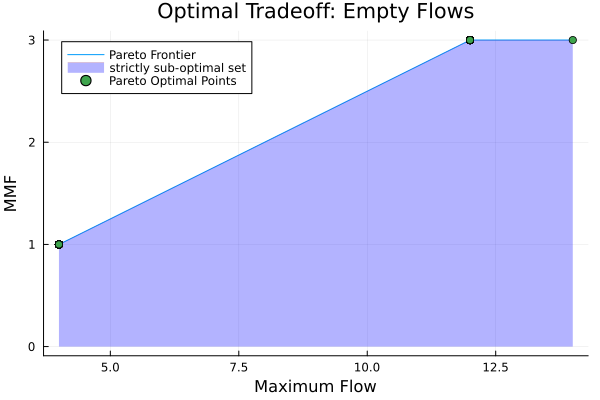

In [28]:
#### SCHEMA #####
############ focus ######## starvation_pen ### empty_flows #######  max_thresh ###### disp ####### bigM
tradeoffMIP("Empty Flows",      10,            3,                    10,              15,         1000)
# set empty_flows to 1

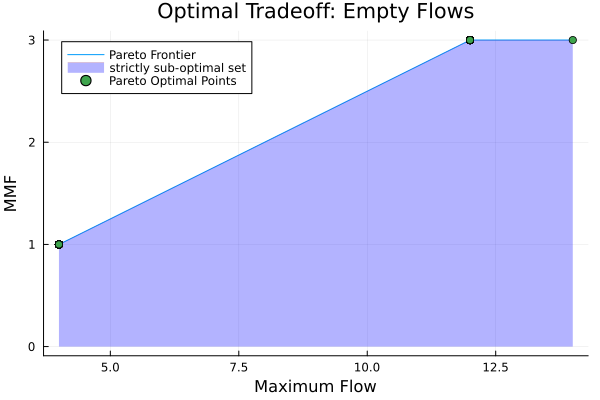

In [14]:
#### SCHEMA #####
############ focus ######## starvation_pen ### empty_flows #######  max_thresh ###### disp ####### bigM
tradeoffMIP("Empty Flows",      10,            2,                    10,              15,         1000)
# set empty_flows to 2

**Interpretation from both graphs from above**: After running the tradeoff curve for multiple values of `empty_flows`, 2 distinct graphs was obtained. In the first instance, when `empty_flows` = 1, we can observe the same graph and behavior from our experiments using `starvation_pen`. However, when we `empty_flows` = 2, we get a solution that involves increasing the value of our Pareto Optimal point when Maximum Flow from 0 in the first graph, to 1 in this case. Of course, this makes sense, because if we become more strict with the number of empty flows for consumers that we allow, we would need to find a solution that avoids making empty flows in the first place. And similar to the `starvation_pen` approach, we can also obtain the same level of Maximum Flow.

#### 4.2.3 Limiting the Maximum Threshold

For the following graphs, we will run our function from section [Section 3.3](#3.3-A-Mixed-Integer-Approach). The plan is to fix all the variables outside of the one the subsection focuses on. In this case, we focus on `max_thresh`, which is explained in our formulation from the previous section!

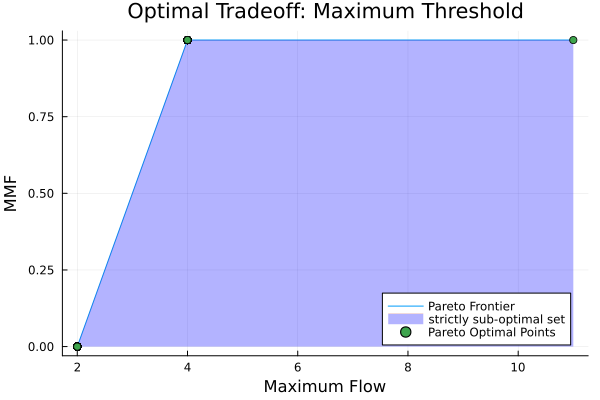

In [15]:
#### SCHEMA #####
############ focus ############## starvation_pen ### empty_flows #######  max_thresh ###### disp ####### bigM
tradeoffMIP("Maximum Threshold",      10,            1,                    2,              15,         1000)
# set max_thresh to 2

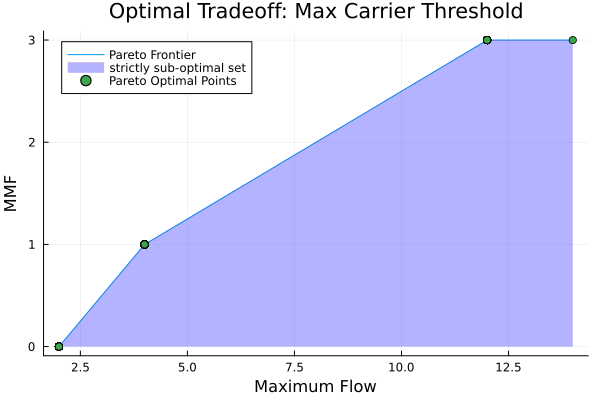

In [16]:
#### SCHEMA #####
############ focus ############## starvation_pen ### empty_flows #######  max_thresh ###### disp ####### bigM
tradeoffMIP("Max Carrier Threshold",      10,            1,                    5,             15,         1000)
# set max_thresh to 5

**Interpretation from both graphs from above**: After running the tradeoff curve for multiple values of `max_thresh`, 2 distinct graphs was obtained. In the first instance, when `max_thresh` is a small value like 2, both our objectives are worse than the other tradeoffs (MMF being topped at 1, while Maximum Flow tops at 12).  On the other hand, we can observe the same graph and behavior from both `starvation_pen` and `empty_flows` when we set `max_thresh` equal to a larger value. Of course, this makes sense, because if we become more strict with the amount of flow the max consumer can get and set it too low, much of the heavy lifting of flow carrying would be depleted, which in turn limits how much fairness there could be (i.e., all consumers are bundled up) and how much Maximum Flow could be lost.

#### 4.2.4 Limiting the Disproportion

For the following graphs, we will run our function from section [Section 3.3](#3.3-A-Mixed-Integer-Approach). The plan is to fix all the variables outside of the one the subsection focuses on. In this case, we focus on `disp`, which is explained in our formulation from the previous section!

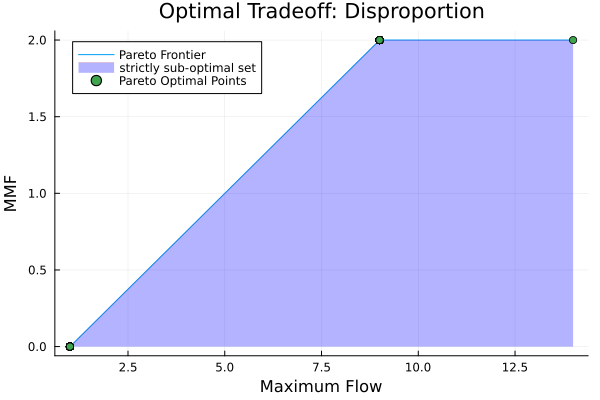

In [24]:
#### SCHEMA #####
############ focus ###### starvation_pen ### empty_flows #######  max_thresh ###### disp ####### bigM
tradeoffMIP("Disproportion",      10,            0,                    100,            0,         1000)
# set disp to 10

**Interpretation for graph above**: After running the tradeoff curve for multiple values of `disp`, the same graph was obtained. Similar to `starvation_pen`, we can see the presence of 4 vertices suggests that there are numerous distinct trade-offs between the two objectives. The presence of many vertices implies a diverse set of solutions along the Pareto front. Each vertex in essence represents a unique combination of objective values that cannot be improved upon without worsening at least one of the objectives. This is great news since this means that to obtain the optimal MMF, there is some wiggle room to further enhance the Maximum Flow, even though it dropped from 18 to 15.

### 4.3 Interpreting the Results at Higher Level

To recap, we can see that our results from section 4.1 (initial study), though fairness can be achieved, it may be insignificant when using single boundary constraints. On the other hand, by using logic constraints in section 4.2, we can consistently achieve a pretty high MMF, but it can also come at the cost of losing some portion of the Maximum Flow. While the experiments showed us that both some level of fairness and overall network flow performance can be obtained, this is also due to the fact that our optimization model and data reflects a static and 'know-it-all' scenario. In real-life crisis, there is limited data and resources, which would in turn lead towards making locally optimal decisions. Of course, it is more than well mentioned in network literature review that a fundamental problem of modeling these supply-chains stems from data availability, and that obtaining said data is both expensive and may be incomplete due to data-gathering practices. Although this problem may push researchers to make strong assumptions, it is part of the tradeoff to perform simulations that could lead to some viable answer. It it also important to recall that our core assumption is that all consumers have some viable path in which flow can pass. Having scenarios in which paths cannot be used make this problem more complex.

## 5. Conclusion ##

***

### 5.1 Closing Remarks

In conclusion, the exploration of network and supply-chain starvation through Mixed-Integer, Multi-Objective Linear Programming has provided valuable insights into the dynamics of resource allocation and fairness. Though more formal and continous experiments were not able to performed, the general idea still holds. By integrating the principles of fairness and Max-Min-Fairness, we have uncovered a understanding of how resource distribution impacts the stability and objective performance of networks and supply-chains. Through this project, we have demonstrated the significance of considering multiple objectives simultaneously, as it allows for a more complete assessment of network performance. The initial study showed that from a more intuitive train of thought, some level of fairness can be achieved by adding simple constraints, but are limited by not having the possible tradeoffs and decisions that could naturally occur in these networks. However, by using logic to optimize for both fairness and efficiency, we can create solutions that not only enhance the overall performance of the system but also promote equity among its participants. The results showed that using even though both our objectives can be slightly correlated, certain logic constraints, like establishing starvation and empty flow thresholds, it is possible to see that both objectives can be improved. Although, in cases like determining how much the maximum consumer node can get, we may get solutions that both negatively affect fairness and Maximum Flow. However, it is important to note that there is no universal definition for fairness, and just like we learned in class, this type of solution and model will have tradeoffs to consider. By identifying and addressing potential bottlenecks and resource imbalances, we can foster resilience within very complex systems. As seen in the results, by tweaking what logic constraint we care about the most, we get interesting types of results that help us understand how can Maximum Flow and MMF relate. Lastly, I want to thank Prof. Lessard for teaching the course!

### 5.2 Future Directions

Among the possibly interesting avenues, there are a core of them which are worth exploring outside the scope of the class. A preliminary avenue would be to extend this study to larger data and to study more complex compositions for these supply-chains (i.e. to make cars, you need multiple unique commodities from upstream nodes). The biggest challenge to achieve it is to obtain somewhat clean data to perform a higher number of simulations. The real first one is to research on more advanced optimization techniques, such as metaheuristic algorithms (e.g., genetic algorithms, simulated annealing) and machine learning-based approaches, to further enhance the efficiency and scalability of the proposed model. These methods could potentially offer more robust solutions for complex, large-scale network and supply-chain optimization problems. The next part would be to extend the analysis to dynamic environments, where network and supply-chain conditions are subject to constant fluctuations and uncertainties. Developing adaptive optimization strategies that can react swiftly to changing conditions will be crucial for ensuring resilience and responsiveness in dynamic systems. Another limitation from this research was to add more success metrics, such as common supply-chain objectives like carbon footprint reduction and energy efficiency, into the optimization framework. By optimizing for both fairness and sustainability objectives simultaneously, we can contribute to the development of environmentally responsible supply chains and networks. Outside of a formal LP modeling approach, it would also be ideal to study the basic notion of network resilience. Some of the earlier work with Maximum Flow was primarily part of network interdiction problems. Though the focus of this line of research lies in protecting the components of a network whose removal impact it the most, there could be a promising avenue of fairness research by exploring which network components span a great deal of the nodes who need some demand met. This can be coupled with $\alpha$ values to determine which network components when protected can ensure the highest possible satisfiable lower bound.

## 6. References ##

***

1. David Simchi-Levi, William Schmidt, Yehua Wei, Peter Yun Zhang, Keith
Combs, Yao Ge, Oleg Gusikhin, Michael Sanders, and Don Zhang. 2015.
Identifying Risks and Mitigating Disruptions in the Automotive Supply
Chain. Interfaces 45, 5 (2015), 375–390. https://doi.org/10.1287/inte.2015.0804
arXiv:https://doi.org/10.1287/inte.2015.0804

2. Thomas C. Sharkey, Sarah G. Nurre Pinkley, Daniel A. Eisenberg, and David L.
Alderson. 2021. In search of network resilience: An optimization-based
view. Networks 77, 2 (2021), 225–254. https://doi.org/10.1002/net.21996
arXiv:https://onlinelibrary.wiley.com/doi/pdf/10.1002/net.21996

3. K. Katsaliaki, P. Galetsi, and S. Kumar. 2022. Supply chain disruptions and
resilience: a major review and future research agenda. Annals of Operations
Research 319, 1 (December 2022), 965–1002. https://doi.org/10.1007/s10479-020-03912

4. D. Nace and M. Pioro. 2018. Max-min fairness and its applications to routing and load-balancing in communication networks: a tutorial. in IEEE Communications Surveys & Tutorials, vol. 10, no. 4, pp. 5-17. doi: 10.1109/SURV.2008.080403

5. Graph Generator. 2023. https://mikhad.github.io/graph-builder/#2023

6.  Wallace J. Hopp Ozlem Ergun and Pinar Keskinocak. 2023. A structured overview of insights and opportunities for enhancing supply chain resilience. IISE Trans- actions 55, 1 (2023), 57–74.https://doi.org/10.1080/24725854.2022.2080892
7.  Timothy Edward Russell, Justin James Boutilier, Sarah Kleinmann, and Jarrod
Goentzel. 2020. Actionable Analysis: Simulating and Visualizing Fuel Distribution
During Disasters. (2020)